In [1]:
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import warnings
import tensorflow as tf
from keras.models import Sequential
from keras.layers import LSTM, Dropout
from keras.layers import Dense

from sklearn.model_selection import train_test_split
from keras.preprocessing.sequence import TimeseriesGenerator
from sklearn.preprocessing import MinMaxScaler, StandardScaler

warnings.filterwarnings('ignore')

mpl.rcParams['figure.figsize'] = [12, 8]
mpl.rcParams['axes.grid'] = False
sns.set(style="whitegrid", font_scale=1.5)

df_GDP = pd.read_csv('./dataset/GDPC1.csv')
df_UNEMP = pd.read_csv('./dataset/UNEMP.csv')
df_FEDINTRate = pd.read_csv('./dataset/FedFundEffectiveRate.csv')
df_INF = pd.read_csv('./dataset/INFLATION.csv')
df_AAABondYield = pd.read_csv('./dataset/MoodyAaaCorporateBondYield.csv')
df_FEDDebt = pd.read_csv('./dataset/FEDDEBT.csv')
df_3MTBills = pd.read_csv('./dataset/3MTBill.csv')
df_SP500 = pd.read_csv('./dataset/SP500_1.csv')

def set_date_index(dataframe, col = "DATE"):
    dataframe[col] = pd.to_datetime(dataframe[col])
    
def set_to_numeric(dataframe, col):
    dataframe[col] = pd.to_numeric(dataframe[col])

def merge_datasets(features, target):
    for feature in features:
        target = target.merge(feature, how='left', on='DATE')
    return target

2023-08-01 22:04:07.635863: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
df_SP500.describe()

,Open,High,Low,Close
count,5930.000000,5930.000000,5930.000000,5930.000000
mean,1928.514442,1940.043705,1916.199410,1928.831295
std,1016.264475,1021.531037,1010.712063,1016.514364
min,675.130000,695.270000,666.790000,676.530000
25%,1188.287500,1195.407500,1180.982500,1188.820000
50%,1447.055000,1456.755000,1436.335000,1447.135000
75%,2469.005000,2477.875000,2460.207500,2471.987500
max,4804.510000,4818.620000,4780.040000,4796.560000


In [3]:
df_SP500.rename(columns={'Date' : 'DATE', ' Close': 'Close'}, inplace=True)
df_SP500.drop(columns=[' Open', ' High', ' Low'], inplace=True)
set_date_index(df_SP500)

In [4]:
features = [df_GDP, df_UNEMP, df_FEDINTRate, df_INF, df_AAABondYield, df_FEDDebt, df_3MTBills]
#setting date column as index index
for df in features:
    set_date_index(df)

In [5]:
#df_AAABondYield
df_AAABondYield['DAAA'].replace(".", method='ffill', inplace=True )
df_AAABondYield.rename(columns={'DAAA' : 'BOND_YIELD'}, inplace=True)
set_to_numeric(df_AAABondYield, 'BOND_YIELD')

In [6]:
df_INF['T10YIE'].replace(".", method='ffill', inplace=True )
df_INF.rename(columns={'T10YIE' : 'INF'}, inplace=True)
set_to_numeric(df_INF, 'INF')

In [7]:
df_3MTBills['DTB3'].replace(".", method='ffill', inplace=True )
df_3MTBills.rename(columns={'DTB3' : '3M_TBILLS'}, inplace=True)
set_to_numeric(df_3MTBills, '3M_TBILLS')

In [8]:
#df_gdp
df_GDP.rename(columns={'GDPC1' : 'GDP'}, inplace = True)
set_to_numeric(df_GDP, 'GDP')

In [9]:
#df_unemployment
df_UNEMP.rename(columns={'UNRATE' : 'UNEMP_RATE'}, inplace=True)
set_to_numeric(df_UNEMP, 'UNEMP_RATE')

In [10]:
#df_fedInterestRate
df_FEDINTRate.rename(columns={'DFF' : 'INT_RATE'}, inplace=True)
set_to_numeric(df_FEDINTRate, 'INT_RATE')

In [11]:
#df_fedDebt
df_FEDDebt.rename(columns={'GFDEBTN' : 'GOVT_DEBT'}, inplace=True)
set_to_numeric(df_FEDDebt, 'GOVT_DEBT')

In [12]:
dataset_input = merge_datasets(features, df_SP500)

In [13]:
dataset_input.fillna(method='ffill', inplace=True)

In [14]:
dataset_input.isna().sum()

DATE            0
Close           0
GDP           269
UNEMP_RATE     39
INT_RATE        4
INF             3
BOND_YIELD      4
GOVT_DEBT     269
3M_TBILLS       4
dtype: int64

In [15]:
dataset_input.dropna(inplace=True)

In [16]:
dataset_input.describe()

,Close,GDP,UNEMP_RATE,INT_RATE,INF,BOND_YIELD,GOVT_DEBT,3M_TBILLS
count,5661.000000,5661.000000,5661.000000,5661.000000,5661.000000,5661.000000,5.661000e+03,5661.000000
mean,1828.303310,16390.813809,6.062939,1.616169,2.008467,4.757009,1.522037e+07,1.481203
std,925.935974,1961.268688,2.203219,1.875895,0.414319,1.333459,7.362522e+06,1.730611
min,676.530000,13284.881000,3.500000,0.040000,0.040000,2.010000,5.943439e+06,-0.050000
25%,1178.840000,15161.772000,4.500000,0.130000,1.640000,3.780000,9.229172e+06,0.090000
50%,1418.260000,15876.839000,5.400000,0.990000,2.060000,4.750000,1.479034e+07,0.920000
75%,2186.900000,17724.489000,7.200000,2.310000,2.340000,5.580000,2.197410e+07,2.180000
max,4796.560000,20054.663000,14.700000,7.030000,3.020000,8.120000,3.092891e+07,6.240000


In [17]:
scaler = MinMaxScaler()

In [18]:
data_scaled = scaler.fit_transform(dataset_input.loc[:, ~dataset_input.columns.isin(['DATE'])])

In [19]:
data_scaled

array([[0.76426628, 1.        , 0.        , ..., 0.36824877, 1.        ,
        0.2718601 ],
       [0.75456975, 1.        , 0.        , ..., 0.35679214, 1.        ,
        0.2718601 ],
       [0.76268862, 1.        , 0.        , ..., 0.36006547, 1.        ,
        0.28298887],
       ...,
       [0.17611037, 0.        , 0.05357143, ..., 0.94435352, 0.        ,
        0.84737679],
       [0.17545746, 0.        , 0.05357143, ..., 0.92962357, 0.        ,
        0.84578696],
       [0.18900105, 0.        , 0.05357143, ..., 0.93944354, 0.        ,
        0.84578696]])

In [20]:
trainX = []
trainY = []

n_future = 1
n_past = 14

for i in range(n_past, len(data_scaled) - n_future + 1):
    trainX.append(data_scaled[i - n_past: i, 0: data_scaled.shape[1]])
    trainY.append(data_scaled[i + n_future - 1: i + n_future, 0])

In [23]:
trainX[1]

array([[0.75456975, 1.        , 0.        , 0.22031474, 0.76845638,
        0.35679214, 1.        , 0.2718601 ],
       [0.76268862, 1.        , 0.        , 0.22031474, 0.77852349,
        0.36006547, 1.        , 0.28298887],
       [0.76334881, 1.        , 0.        , 0.22031474, 0.81879195,
        0.37479542, 1.        , 0.28616852],
       [0.78241663, 1.        , 0.        , 0.22031474, 0.84228188,
        0.37315876, 1.        , 0.28616852],
       [0.78523943, 1.        , 0.        , 0.22031474, 0.84563758,
        0.36661211, 1.        , 0.2718601 ],
       [0.75708187, 1.        , 0.        , 0.22031474, 0.82550336,
        0.36006547, 1.        , 0.26073132],
       [0.7483829 , 1.        , 0.        , 0.22031474, 0.83892617,
        0.36988543, 1.        , 0.25755167],
       [0.74957221, 1.        , 0.        , 0.22031474, 0.86241611,
        0.39116203, 1.        , 0.2718601 ],
       [0.72773985, 1.        , 0.        , 0.22031474, 0.85234899,
        0.37806874, 1.      

In [22]:
trainY[0]

array([0.78259867])

In [23]:
trainX, trainY = np.array(trainX), np.array(trainY)

In [26]:
model = Sequential()
#model.add(LSTM(64, activation='relu', input_shape=(trainX.shape[1], trainX.shape[2]), return_sequences=True))
#model.add(LSTM(64, activation='relu', return_sequences=False))
#model.add(Dropout(0.2))
#model.add(Dense(trainY.shape[1]))

#model.compile(optimizer='adam', loss='mse')
#model.summary()

model = Sequential()
model.add(LSTM(128, activation='relu', input_shape=(trainX.shape[1], trainX.shape[2]), return_sequences=True))
model.add(LSTM(128, activation='relu', return_sequences=True))
model.add(Dropout(0.3))
model.add(LSTM(64, activation='relu', return_sequences=False))
model.add(Dropout(0.3))
model.add(Dense(1))

model.compile(optimizer='adam', loss='mse')
model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_2 (LSTM)               (None, 14, 128)           70144     
                                                                 
 lstm_3 (LSTM)               (None, 14, 128)           131584    
                                                                 
 dropout_1 (Dropout)         (None, 14, 128)           0         
                                                                 
 lstm_4 (LSTM)               (None, 64)                49408     
                                                                 
 dropout_2 (Dropout)         (None, 64)                0         
                                                                 
 dense_1 (Dense)             (None, 1)                 65        
                                                                 
Total params: 251,201
Trainable params: 251,201
Non-tr

In [27]:
history = model.fit(trainX, trainY, epochs=100, batch_size=32, validation_split=0.2, verbose=1)
model.fit_generator

Epoch 1/100
142/142 [==============================] - 6s 21ms/step - loss: 0.0127 - val_loss: 0.0014
Epoch 2/100
142/142 [==============================] - 4s 25ms/step - loss: 0.0036 - val_loss: 0.0016
Epoch 3/100
142/142 [==============================] - 3s 19ms/step - loss: 0.0031 - val_loss: 7.6771e-04
Epoch 4/100
142/142 [==============================] - 3s 18ms/step - loss: 0.0030 - val_loss: 8.1883e-04
Epoch 5/100
142/142 [==============================] - 2s 17ms/step - loss: 0.0025 - val_loss: 0.0017
Epoch 6/100
142/142 [==============================] - 2s 17ms/step - loss: 0.0020 - val_loss: 0.0015
Epoch 7/100
142/142 [==============================] - 2s 17ms/step - loss: 0.0021 - val_loss: 9.3775e-04
Epoch 8/100
142/142 [==============================] - 2s 17ms/step - loss: 0.0017 - val_loss: 0.0013
Epoch 9/100
142/142 [==============================] - 2s 17ms/step - loss: 0.0017 - val_loss: 8.9102e-04
Epoch 10/100
142/142 [==============================] - 2s 17ms/st

<bound method Model.fit_generator of <keras.engine.sequential.Sequential object at 0x146d97b90>>

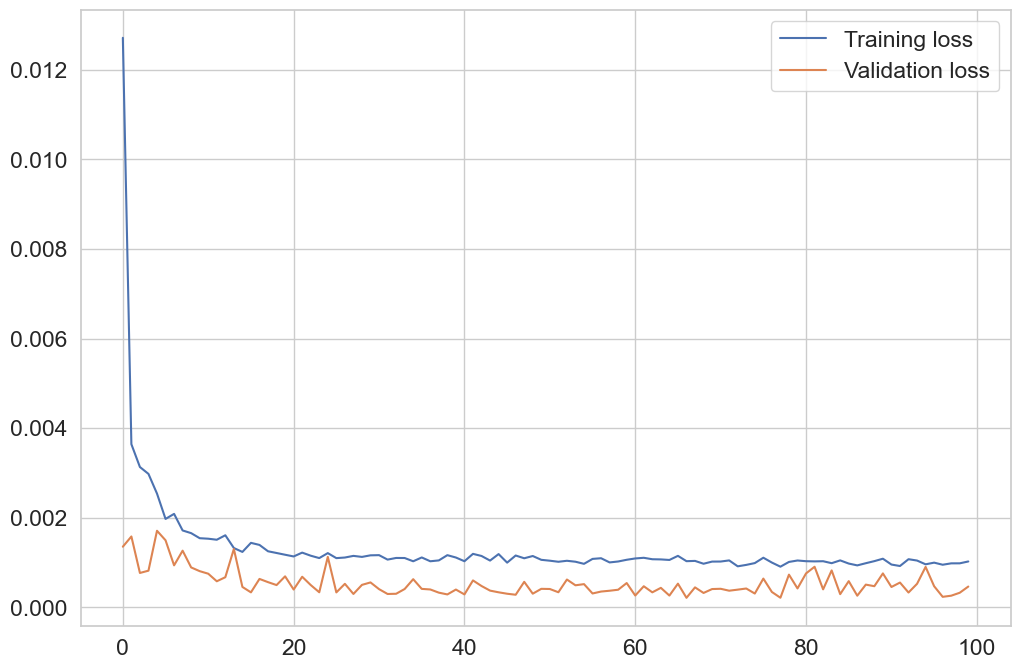

In [28]:
plt.plot(history.history['loss'], label='Training loss')
plt.plot(history.history['val_loss'], label="Validation loss")
plt.legend()
plt.show()